## Market prices & Arbitrage

In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame, skipping the first 6 rows which are just information
file_path = '/content/Inflation_MVM market-experiment-table.csv'
data = pd.read_csv(file_path, skiprows=6)

# Display the first few rows of the dataframe to understand its structure
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10020 entries, 0 to 10019
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   [run number]             10020 non-null  int64  
 1   num-markets-per-region   10020 non-null  int64  
 2   num-regions              10020 non-null  int64  
 3   num-consumers            10020 non-null  int64  
 4   num-factories            10020 non-null  int64  
 5   num-producers            10020 non-null  int64  
 6   num-households           10020 non-null  int64  
 7   [step]                   10020 non-null  int64  
 8   collect-market-prices    10020 non-null  object 
 9   calculate-average-price  10020 non-null  float64
dtypes: float64(1), int64(8), object(1)
memory usage: 782.9+ KB


In [ ]:
import re

def clean_prices(messy_prices):
    cleaned_prices = []
    pattern = r'\[(\[-?\d+\s+-?\d+\])\s*([\d.]+)\]'
    for row in messy_prices:
        markets = re.findall(pattern, row)
        cleaned_row = []
        for market in markets:
            coords_str = market[0]
            coords = [int(x) for x in coords_str[1:-1].split()]
            price = float(market[1])
            cleaned_row.append({"coords": coords, "price": price})
        cleaned_prices.append(cleaned_row)
    return cleaned_prices

messy_prices = data.sort_values(['[run number]', '[step]'], ascending=True)['collect-market-prices']
cleaned_prices = clean_prices(messy_prices)

In [ ]:
data['cleaned_prices'] = clean_prices(data['collect-market-prices'])
data.head()

,[run number],num-markets-per-region,num-regions,num-consumers,num-factories,num-producers,num-households,[step],collect-market-prices,calculate-average-price,cleaned_prices
0,1,1,1,2,2,2,2,0,[[[-1 21] 10]],10.000000,"[{'coords': [-1, 21], 'price': 10.0}]"
1,1,1,1,2,2,2,2,1,[[[-1 21] 9.5]],9.500000,"[{'coords': [-1, 21], 'price': 9.5}]"
2,1,1,1,2,2,2,2,2,[[[-1 21] 9.025]],9.025000,"[{'coords': [-1, 21], 'price': 9.025}]"
3,1,1,1,2,2,2,2,3,[[[-1 21] 8.574]],8.573750,"[{'coords': [-1, 21], 'price': 8.574}]"
4,1,1,1,2,2,2,2,4,[[[-1 21] 8.145]],8.145062,"[{'coords': [-1, 21], 'price': 8.145}]"


In [ ]:
import ast

# Convert the cleaned_prices to a string representation
data['cleaned_prices_str'] = data['cleaned_prices'].apply(lambda x: str(x))

market_data = []

for (run_number, step), group in data.groupby(['[run number]', '[step]']):
    num_markets_per_region = group['num-markets-per-region'].unique()[0]
    num_regions = group['num-regions'].unique()[0]

    for coords_str, price_series in group.groupby('cleaned_prices_str')['calculate-average-price']:
        coords = ast.literal_eval(coords_str)
        market_info = {
            'run_number': run_number,
            'ticks': step,
            'num_markets_per_region': num_markets_per_region,
            'num_regions': num_regions,
            'coords': [d['coords'] for d in coords],  # Store a list of coords
            'prices': [d['price'] for d in coords]
        }
        market_data.append(market_info)

market_df = pd.DataFrame(market_data)
market_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10020 entries, 0 to 10019
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   run_number              10020 non-null  int64 
 1   ticks                   10020 non-null  int64 
 2   num_markets_per_region  10020 non-null  int64 
 3   num_regions             10020 non-null  int64 
 4   coords                  10020 non-null  object
 5   prices                  10020 non-null  object
dtypes: int64(4), object(2)
memory usage: 469.8+ KB


The more markets in the local economy, the more competition there exists, and therefore the higher the opportunity to arbitrage. This competition should drive prices down initially, until one (if any) of the markets is able to capture most of the demand at a higher price and form a monopoly. Thus, the more markets considered, at fixed number of consumers and producers, should increase the probability of a monopoly forming and hence prices skyrocketing.

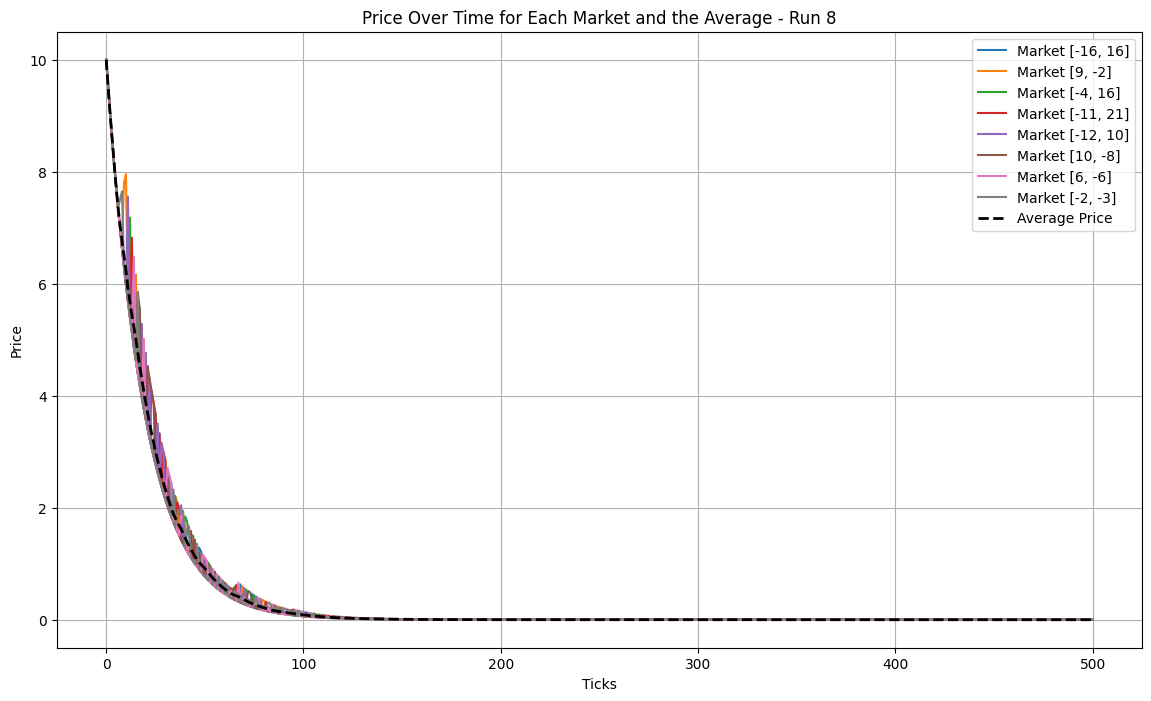

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_market_prices_over_time(market_df, run_number):
    # Filter the dataframe for the specified run number
    run_data = market_df[market_df['run_number'] == run_number]

    # Determine the number of markets in this run
    num_markets = run_data.iloc[0]['num_regions'] * run_data.iloc[0]['num_markets_per_region']

    # Set up the plot
    plt.figure(figsize=(14, 8))
    plt.title(f'Price Over Time for Each Market and the Average - Run {run_number}')
    plt.xlabel('Ticks')
    plt.ylabel('Price')

    # Initialize a list to store all market prices per tick for calculating the average
    all_market_prices = []

    # Plot a line for each market
    for market_index in range(num_markets):
        prices = []

        # Extract prices for each tick for the market index
        for _, row in run_data.iterrows():
            coords_list = row['coords']
            prices_list = row['prices']
            if len(coords_list) > market_index:
                prices.append(prices_list[market_index])

        # Add prices to the list of all markets' prices
        all_market_prices.append(prices)

        # Plot the price data
        plt.plot(run_data['ticks'], prices, label=f'Market {run_data.iloc[0]["coords"][market_index]}')

    # Calculate the average price across all markets at each tick
    average_prices = np.mean(all_market_prices, axis=0)
    plt.plot(run_data['ticks'], average_prices, label='Average Price', color='black', linewidth=2, linestyle='--')

    # Add a legend to the plot
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage of the function to plot price data for run number 2
plot_market_prices_over_time(market_df, run_number=8)


## Consumer Price Expectations

In [ ]:
price_expectations = pd.read_csv("/content/Inflation_MVM consumer-experiment-table.csv", skiprows=6)
price_expectations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29237 entries, 0 to 29236
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   [run number]            29237 non-null  int64
 1   num-markets-per-region  29237 non-null  int64
 2   num-regions             29237 non-null  int64
 3   num-consumers           29237 non-null  int64
 4   num-factories           29237 non-null  int64
 5   num-producers           29237 non-null  int64
 6   num-households          29237 non-null  int64
 7   [step]                  29237 non-null  int64
 8   num-expect-up           29237 non-null  int64
 9   num-expect-stay         29237 non-null  int64
 10  num-expect-down         29237 non-null  int64
dtypes: int64(11)
memory usage: 2.5 MB


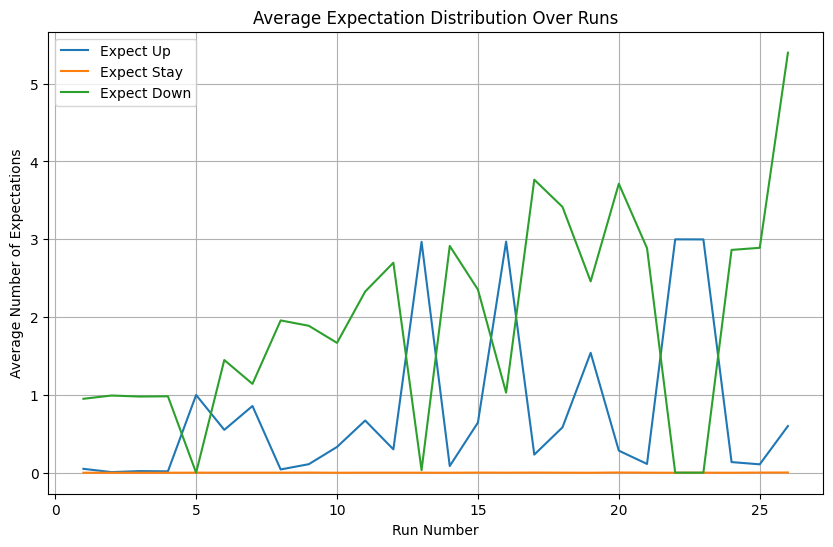

In [ ]:
mean_grouped_data = price_expectations[['[run number]', "num-expect-up", 'num-expect-stay', 'num-expect-down']].groupby('[run number]').mean()

# Plotting the results
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.plot(mean_grouped_data['num-expect-up'], label='Expect Up')
plt.plot(mean_grouped_data['num-expect-stay'], label='Expect Stay')
plt.plot(mean_grouped_data['num-expect-down'], label='Expect Down')

plt.title('Average Expectation Distribution Over Runs')
plt.xlabel('Run Number')
plt.ylabel('Average Number of Expectations')
plt.legend()  # Adds a legend to identify each line
plt.grid(True)  # Adds a grid for easier readability

plt.show()

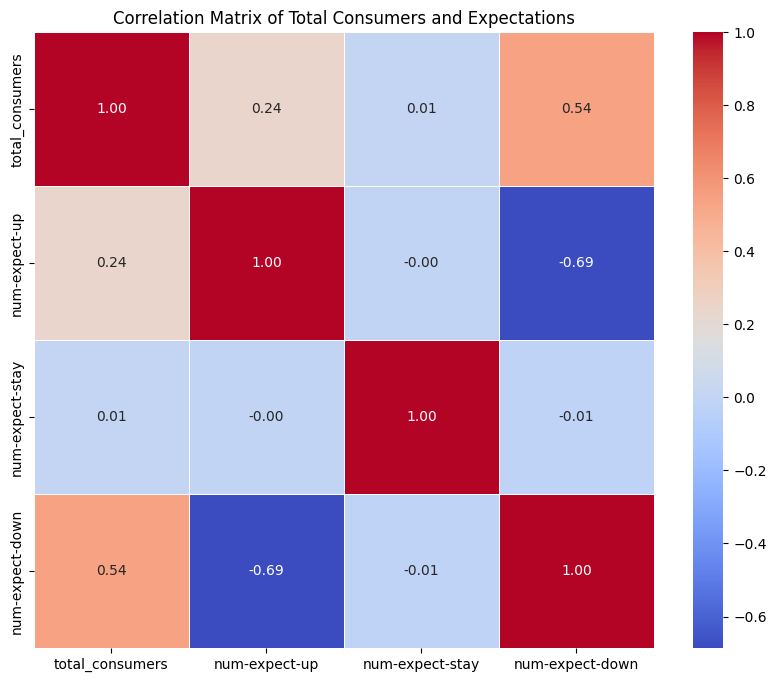

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate total consumers
price_expectations['total_consumers'] = price_expectations['num-households'] * price_expectations['num-consumers']

# Select relevant columns for correlation analysis
data_for_analysis = price_expectations[['total_consumers', 'num-expect-up', 'num-expect-stay', 'num-expect-down']]

# Calculate the correlation matrix
correlation_matrix = data_for_analysis.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Total Consumers and Expectations')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Prepare the data
X = price_expectations[['total_consumers']]  # Independent variable
y = price_expectations['num-expect-down']  # Dependent variable for this example

# Add a constant to the independent variable if using statsmodels
X = sm.add_constant(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Build and train the model using statsmodels
model = sm.OLS(y_train, X_train).fit()

# Evaluate the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        num-expect-down   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     9568.
Date:                Tue, 30 Apr 2024   Prob (F-statistic):               0.00
Time:                        02:59:59   Log-Likelihood:                -38783.
No. Observations:               23389   AIC:                         7.757e+04
Df Residuals:                   23387   BIC:                         7.759e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.2353      0.022    -

In [ ]:
model.summary().as_latex()

'\\begin{center}\n\\begin{tabular}{lclc}\n\\toprule\n\\textbf{Dep. Variable:}    & num-expect-down  & \\textbf{  R-squared:         } &     0.290   \\\\\n\\textbf{Model:}            &       OLS        & \\textbf{  Adj. R-squared:    } &     0.290   \\\\\n\\textbf{Method:}           &  Least Squares   & \\textbf{  F-statistic:       } &     9568.   \\\\\n\\textbf{Date:}             & Tue, 30 Apr 2024 & \\textbf{  Prob (F-statistic):} &     0.00    \\\\\n\\textbf{Time:}             &     03:00:22     & \\textbf{  Log-Likelihood:    } &   -38783.   \\\\\n\\textbf{No. Observations:} &       23389      & \\textbf{  AIC:               } & 7.757e+04   \\\\\n\\textbf{Df Residuals:}     &       23387      & \\textbf{  BIC:               } & 7.759e+04   \\\\\n\\textbf{Df Model:}         &           1      & \\textbf{                     } &             \\\\\n\\textbf{Covariance Type:}  &    nonrobust     & \\textbf{                     } &             \\\\\n\\bottomrule\n\\end{tabular}\n\\begin{

In [ ]:
from statsmodels.discrete.count_model import ZeroInflatedPoisson
import statsmodels.api as sm
import numpy as np

def fit_zero_inflated_poisson(data, independent_var, dependent_var):
    """
    Fits a Zero-Inflated Poisson regression model and returns the summary.

    Parameters:
    data (DataFrame): The data to use in the model.
    independent_var (str): The name of the independent variable.
    dependent_var (str): The name of the dependent variable to model.

    Returns:
    ZeroInflatedPoissonResults: The results of the fitted ZIP model.
    """
    # Prepare the data
    X = data[[independent_var]]
    y = data[dependent_var]

    # Add a constant to the independent variable
    X = sm.add_constant(X)

    # Fit the Zero-Inflated Poisson model
    zip_model = ZeroInflatedPoisson(endog=y, exog=X, exog_infl=X, inflation='logit').fit()

    return zip_model

# Example usage for 'num-expect-down':
zip_results_down = fit_zero_inflated_poisson(price_expectations, 'total_consumers', 'num-expect-down')
print(zip_results_down.summary())


Optimization terminated successfully.
         Current function value: 1.521971
         Iterations: 18
         Function evaluations: 21
         Gradient evaluations: 21
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:         num-expect-down   No. Observations:                29237
Model:             ZeroInflatedPoisson   Df Residuals:                    29235
Method:                            MLE   Df Model:                            1
Date:                 Tue, 30 Apr 2024   Pseudo R-squ.:                  0.1019
Time:                         03:00:49   Log-Likelihood:                -44498.
converged:                        True   LL-Null:                       -49548.
Covariance Type:             nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
infl

In [ ]:
zip_results_down.summary().as_latex()

'\\begin{center}\n\\begin{tabular}{lclc}\n\\toprule\n\\textbf{Dep. Variable:}            &   num-expect-down   & \\textbf{  No. Observations:  } &    29237    \\\\\n\\textbf{Model:}                    & ZeroInflatedPoisson & \\textbf{  Df Residuals:      } &    29235    \\\\\n\\textbf{Method:}                   &         MLE         & \\textbf{  Df Model:          } &        1    \\\\\n\\textbf{Date:}                     &   Tue, 30 Apr 2024  & \\textbf{  Pseudo R-squ.:     } &   0.1019    \\\\\n\\textbf{Time:}                     &       03:00:57      & \\textbf{  Log-Likelihood:    } &   -44498.   \\\\\n\\textbf{converged:}                &         True        & \\textbf{  LL-Null:           } &   -49548.   \\\\\n\\textbf{Covariance Type:}          &      nonrobust      & \\textbf{  LLR p-value:       } &    0.000    \\\\\n\\bottomrule\n\\end{tabular}\n\\begin{tabular}{lcccccc}\n                                   & \\textbf{coef} & \\textbf{std err} & \\textbf{z} & \\textbf{P$> |$z$|

In [ ]:
import statsmodels.api as sm
import pandas as pd

def summarize_zip_results(data, independent_var, dependent_var):
    """
    Fits a Zero-Inflated Poisson regression model and returns a summary DataFrame
    with the most relevant results.

    Parameters:
    data (DataFrame): The data to use in the model.
    independent_var (str): The name of the independent variable.
    dependent_var (str): The name of the dependent variable to model.

    Returns:
    DataFrame: Summary of the ZIP model for the specified independent variable.
    """
    # Fit the Zero-Inflated Poisson model
    X = data[[independent_var]]
    y = data[dependent_var]
    X = sm.add_constant(X)
    zip_model = sm.ZeroInflatedPoisson(endog=y, exog=X, exog_infl=X, inflation='logit').fit()

    # Extract relevant information
    summary_data = {
        'Coefficient': zip_model.params[independent_var],
        'Std Err': zip_model.bse[independent_var],
        'z-value': zip_model.tvalues[independent_var],
        'P>|z|': zip_model.pvalues[independent_var],
        'Conf. Interval Lower': zip_model.conf_int().loc[independent_var, 0],
        'Conf. Interval Upper': zip_model.conf_int().loc[independent_var, 1]
    }

    summary_df = pd.DataFrame(summary_data, index=[independent_var])

    return summary_df

# Example usage:
zip_summary = summarize_zip_results(price_expectations, 'total_consumers', 'num-expect-down')
print(zip_summary)


Optimization terminated successfully.
         Current function value: 1.521971
         Iterations: 18
         Function evaluations: 21
         Gradient evaluations: 21
                 Coefficient   Std Err     z-value  P>|z|  \
total_consumers     0.354081  0.003366  105.205951    0.0   

                 Conf. Interval Lower  Conf. Interval Upper  
total_consumers              0.347484              0.360677  
